# Volatility Timing

Recall our earlier formula

$$x_t=\frac{E_t[r_{t+1}-r^f_{t+1}]}{\gamma Var_t(r_{t+1})}$$

Before we had $x_t=\frac{E_t[r_{t+1}-r^f_{t+1}]}{\gamma Var(r_{t+1})}$

Now we will look at the other extreme $x_t=\frac{E[r_{t+1}-r^f_{t+1}]}{\gamma Var_t(r_{t+1})}$

(note the subscripts!!! )



>The crucial necessary condition for this to work is that there is no time-series relationship between expected returns and variance (or at the very least that this relationship is weak enough)
>
>$$cov(E_t[r_{t+1}-r^f_{t+1}],Var_t(r_{t+1}))=0$$

>- This is key. Might or might not be true depending on asset/strategy.
>- But tends to be true.
>- This only works if the alpha/premium is positive to begin with
>- If Sharpe ratio is zero, you can't increase it by managing risk!
>- This is also true for market timing! You can see that if variance and expected returns moved tightly together you would never trade!
>- Note that both things can happen at the same time, as long they don't move exactly together you can time both!


One can think of minimum-variance investing in the time-series--just like if you believed expected are constant across assets you would simply swing to minimize vol.



For any trading strategy the  volatility timing portfolio is $w_i=\frac{E[r_{t+1}-r^f_{t+1}]}{Var_t(r_{t+1})}$




If expected returns  are time-varying but Sharpe ratios are constant, i.e. $E[r_{t+1}-r^f_{t+1}]=k\sigma_{t}$, then the optimal allocation becomes proportion to inverse volatility $w_i=k{\sigma_{t}}$. In this case you would do a volatility-managed portfolio instead of a "variance-managed" portfolio.

## Libraries and Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as DataReader

def get_factors(factors='CAPM',freq='daily'):

    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]


        df_factor = daily_data[['RF','Mkt-RF']]
    elif factors=='FF3':
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')

    else:
        fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')
        fama_french = DataReader.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)



    return df_factor/100


## Volatility Timing the Market Portfolio
  
>ALAN MOREIRA, TYLER MUIR, Volatility-Managed Portfolios, Journal of Finance, August 2017
https://doi.org/10.1111/jofi.12513
>
>Show that this logic works for the market and many other factors.
>
>Since then a huge literature has emerged showing that volatility managing is a great way to boost Sharpe Ratios

The construct portfolios

$$x_t=c\frac{E[r^e_{t+1}]}{Var_t(r^e_{t+1})}$$


The key is to construct a good measure for $ Var_t(r^e_{t+1})$

* We will do something simple and use past vol as a proxy for future vol
* Of course whether is a good proxy or not depends of how it plays out in the data
* But we already saw that for the market past vol dos a really good job

* Using daily data for month t, construct the market return "realized variance" during month t like we did in our estimation sample lecture
   
   $$rv_t=\sum_{d \in days~ in ~month ~t}\frac{(r_d- \overline{r})^2}{N_{days}},$$
   
 where $\overline{r}$ is the average return within the month

We will need daily data to do this

In [ ]:
df_factor = get_factors()
df_factor.head()


/tmp/ipython-input-3148458022.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")


,RF,Mkt-RF
Date,,
1926-07-01,0.00009,0.0009
1926-07-02,0.00009,0.0045
1926-07-06,0.00009,0.0017
1926-07-07,0.00009,0.0009
1926-07-08,0.00009,0.0022


 **Constructing monthly realized variance from daily data**


You basically use pandas time series function that shifts all dates to the end of the month, so this way you are technically grouping by the end of the month day. We did this before!

We then will do the same with our daily returns to get monthly returns

In [ ]:
RV=df_factor[['Mkt-RF']].groupby(df_factor.index+pd.offsets.MonthEnd(0)).var()*252

RV=RV.rename(columns={'Mkt-RF':'RV'})

# aggregate daily returns to monthly returns
Ret=(1+df_factor).groupby(df_factor.index+pd.offsets.MonthEnd(0)).prod()-1
# Merge Ret (monthly return) with RV (realized variance and weights)
df=RV.merge(Ret,how='left',left_index=True,right_index=True)
# construct excess returns

# lag RV by one month
df['RV_lag']=df['RV'].shift(1)

df.mean()

,0
RV,0.028825
RF,0.002691
Mkt-RF,0.006896
RV_lag,0.028841


## Intuition

- Before build the strategy it is useful to see WHY it works

- For Vol timing to payoff we need that
  - when vol goes up the risk-return trade-off goes down
  - When vol goes dow the risk-return trade-off goes up


$$Cov(RV_t,\frac{r_{t+1}-r^f_{t+1}}{RV_{t+1}})<0$$

One way to see if that is true in the data is to sort all months by past vol in buckets

- In bucket 1 go the really low vol months
- In bucket 5 the really high vol months

We then look at how vol and returns were the month after--i.e. we group the month vol and the month return by past vol!


In [ ]:
# Create quantile groups based on the RV variable

# pd.qcut splits the 'RV_lag' column into 5 quantile-based groups,
# meaning they group the data into 5 equal-sized bins based on the values of 'RV_lag'.
# ensuring that each group has approximately the same number of observations.
df['Quantile'] = pd.qcut(df['RV_lag'], q=5)
df

,RV,RF,Mkt-RF,RV_lag,Quantile
Date,,,,,
1926-07-31,0.005116,0.002252,0.029054,NaN,NaN
1926-08-31,0.008827,0.002603,0.026493,0.005116,"(-0.00022600000000000007, 0.00632]"
1926-09-30,0.006117,0.002162,0.003627,0.008827,"(0.00632, 0.00997]"
1926-10-31,0.017660,0.003255,-0.032814,0.006117,"(-0.00022600000000000007, 0.00632]"
1926-11-30,0.003628,0.003125,0.025747,0.017660,"(0.017, 0.0323]"
...,...,...,...,...,...
2025-02-28,0.019447,0.003235,-0.024214,0.020641,"(0.017, 0.0323]"
2025-03-31,0.047814,0.003365,-0.064063,0.019447,"(0.017, 0.0323]"
2025-04-30,0.252127,0.003576,-0.008223,0.047814,"(0.0323, 0.862]"


/tmp/ipython-input-3050817006.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_means = df.groupby('Quantile').mean()


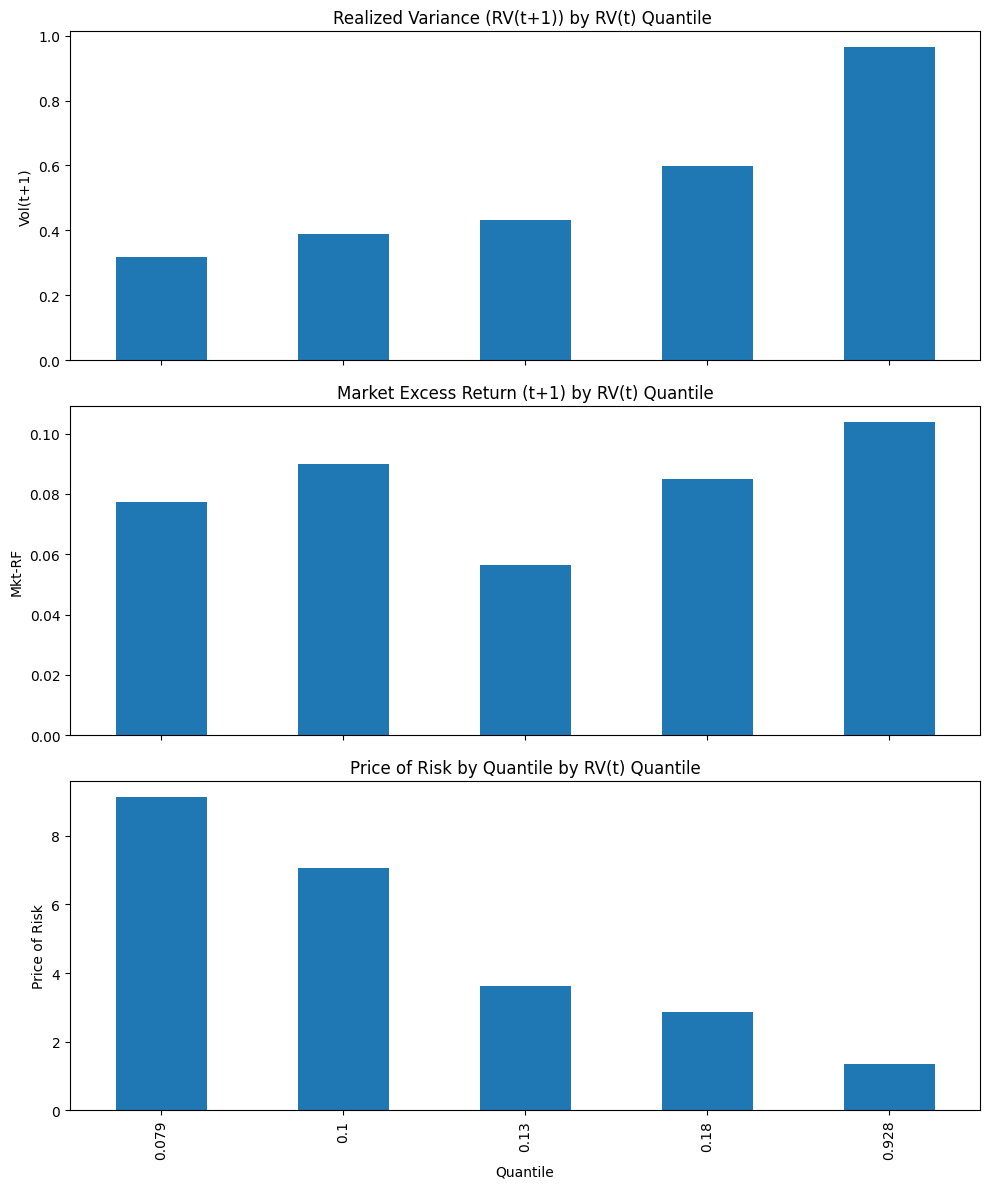

In [ ]:

# Group by quantile and calculate the mean for each column
quantile_means = df.groupby('Quantile').mean()
# label the index according the volatility of the highest vol month in the quantile
quantile_means.index = quantile_means.index.map(lambda x: round((x.right)**0.5, 3))



# Display the mean of quantiles for each column

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
((quantile_means.RV*12)**0.5).plot(kind='bar', ax=axs[0])
axs[0].set_title('Realized Variance (RV(t+1)) by RV(t) Quantile ')
axs[0].set_ylabel('Vol(t+1)')

(quantile_means['Mkt-RF']*12).plot(kind='bar', ax=axs[1])
axs[1].set_title('Market Excess Return (t+1) by RV(t) Quantile')
axs[1].set_ylabel('Mkt-RF')


# compute the price of risk--i.e. the ratio of the mean excess return to the mean realized variance
# across the months in each quantile
# importantly these are for the future months, i.e. the mean excess return  and variance for month t+1
# while we used the variance for month t
quantile_means ['priceofrisk']=quantile_means['Mkt-RF']*12/(quantile_means['RV'])

quantile_means.priceofrisk.plot(kind='bar', ax=axs[2])
axs[2].set_title('Price of Risk by Quantile by RV(t) Quantile')
axs[2].set_ylabel('Price of Risk')
axs[2].set_xlabel('Quantile')

plt.tight_layout()
plt.show()


We see that following months of high variance--on the right-- you don't really get higher returns

if you focus on the ratio -- the price of risk

$$E[\frac{r^e_{t+1}}{RV_{t+1}(r^e)}|RV_t]$$

you see that it is massively decreasing with variance

Average returns are not constant with previous month volatility--**but are close to**--

so the natural strategy to exploit this pattern is to lever up when vol is low and reduce exposure when vol is high.

## From signal to weights

Specifically we buy the market at the closing price of month t according to the rule:
   
   $$w_t=\frac{c}{rv_t},$$

   
where $c$ is some constant.

If you want to be very formal you could set $c=\frac{E[r^{MKT}_{t+1}-r^f_{t+1}]}{\gamma}$

But this only controls you average position in the market

   
  * Hold the position for a month
  
  * The returns of the strategy are given by
  
  


  $$ r^{VolTiming}_{t+1}=r^f_{t+1}+\frac{c}{rv_t}(r^{MKT}_{t+1}-r^f_{t+1})$$



* $c$ controls how levered is the strategy on average.

* Here lets keep it simple and simply choose it so that the position on the market is 1 on average

$$E[x_t]=E[c\frac{1}{rv_t}]=1$$

implies $c=\frac{1}{E[\frac{1}{rv_t}]}$



1.0

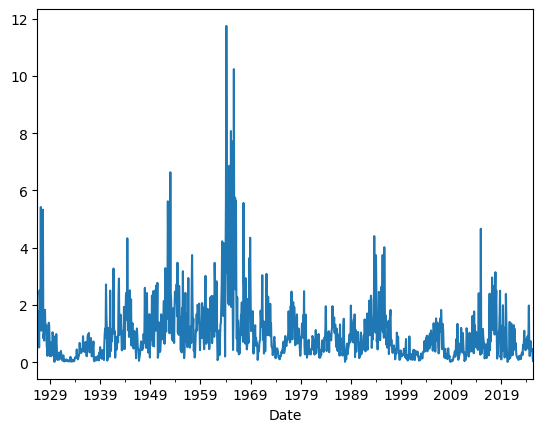

In [ ]:

df['Weight']=1/df.RV_lag
c=1/df['Weight'].mean()
df['Weight']=c*df['Weight']
df.Weight.plot()
df.Weight.mean()

You see that leverage gets really high.

As high as 10!

You can see that in your position in the risk-free rate which exactly mirrors that



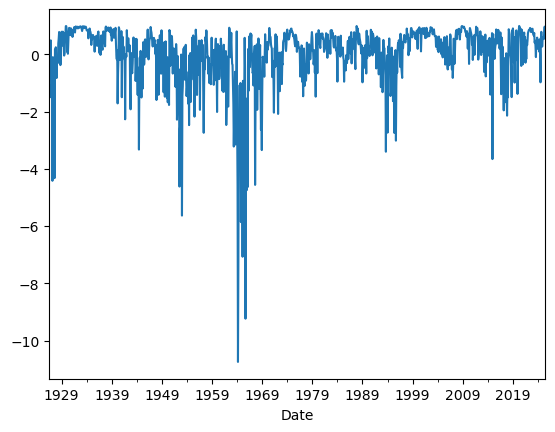

In [ ]:
# plot the weights on the risk-free rate
(1-df.Weight).plot()
plt.show()

## Construct strategy returns

* Now to construct the strategy return recall that we use the realized variance in month t to buy the market at the closing of month t and earn the return accrued in month t+1


* I will call the strategy as $\textbf{VMS}$ (Volatility Managed Strategy)

In [ ]:
# now construct the return of the strategy
df['VMS']=df.Weight*df['Mkt-RF']

We can see the cumulative returns of the market and the volatility managed strategy

<Axes: xlabel='Date'>

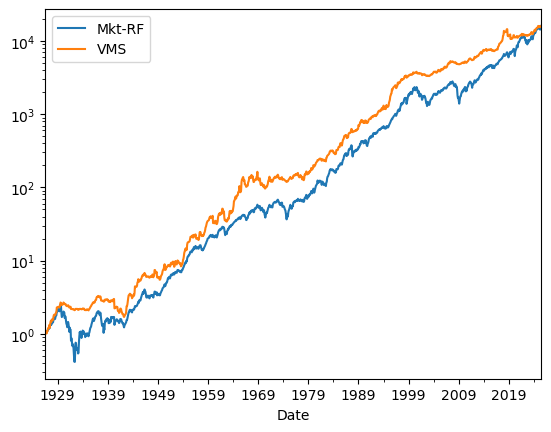

In [ ]:
df[['Mkt-RF','VMS']].add(df['RF']+1,axis=0).cumprod().plot(logy=True)

Does it work or not? Look at the plot and explain to me what you see and why it might work and why it might not.

How to evaluate? What ARE the formal tests/metrics to look at here?

**Things to try**


- How well it works with VIX instead of RV?
- What If we use a forecasting model to predict variance?
- How well it works with standard deviation instead of variance
- How well it works if we put leverage limits. How would you put leverage limits?
- How well it works if we combine an expected return signal with the volatility signal?
- What about the other factors? Does it work there as well?

- Before copying and pasting this code 20 times, simply put it all together in a function

- As you try different things adjust the function to be more flexible


Below is the basic vol managed strategy

It returns the time-series of the strategy returns, but you should all the outcomes you are interest on

In [ ]:
def volmanaged(df):
    factor=df.name
    df=df.dropna()
    endofmonth=df.index+pd.offsets.MonthEnd(0)
    Signal=df.groupby(endofmonth).apply(lambda x: ((x-x.mean())**2).sum())
    Signal=1/Signal.shift(1)
    Signal.name='signal'
    Ret=(1+df).groupby(endofmonth).prod()-1

    df=pd.DataFrame(Signal).merge(Ret,how='left',left_index=True,right_index=True)
    df['Weight']=df.signal
    df['Weight']=df['Weight']/df['Weight'].mean()
    df[factor+'_volmanaged']=df.Weight*df[factor]
    SR_volmanaged=(df[factor+'_volmanaged'].mean()/df[factor+'_volmanaged'].std())*12**0.5
    SR_factor=(df[factor].mean()/df[factor].std())*12**0.5
    return df,SR_volmanaged,SR_factor


df_factor = get_factors('FF6')
volmanaged(df_factor['Mkt-RF'])

/tmp/ipython-input-3148458022.py:40: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
/tmp/ipython-input-3148458022.py:44: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french2 = DataReader.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
/tmp/ipython-input-3148458022.py:49: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  fama_french = DataReader.DataReader("F-F_Momentum_Factor"+fre

(                 signal    Mkt-RF    Weight  Mkt-RF_volmanaged
 Date                                                          
 1926-11-30          NaN  0.021050       NaN                NaN
 1926-12-31  3143.407727  0.026114  2.328047           0.060795
 1927-01-31  2403.152937 -0.000513  1.779805          -0.000913
 1927-02-28  2351.577815  0.042156  1.741608           0.073419
 1927-03-31  7151.401675  0.001374  5.296417           0.007279
 ...                 ...       ...       ...                ...
 2025-02-28   642.572139 -0.024214  0.475897          -0.011523
 2025-03-31   719.917854 -0.064063  0.533180          -0.034157
 2025-04-30   263.521872 -0.008223  0.195168          -0.001605
 2025-05-31    49.974718  0.060498  0.037012           0.002239
 2025-06-30   420.081328  0.048595  0.311117           0.015119
 
 [1184 rows x 4 columns],
 np.float64(0.5147690043930357),
 np.float64(0.44856172378882947))

## 📝 Key Takeaways

-  We care about risk-adjusted returns

- While predicting returns is tricky, predicting variance is much easier

- If variance does NOT predict returns, then we can increase risk-adjusted returns by takign more risk when varianc eis low and less risk with variance is high

- This idea can be applied to individual factors, btu also to your entire portfolio level

- Pod funds are well known for aggressively de-risking when vol spikes. Why is that? Because risk does not predict returns so why risk it?
---